<center>决策树实验</center>
    
# 决策树构建实现

> 根据理论课给出的决策树框架修改课程中的决策树程序代码。

## 模型解构

检测数据集中的每个子项是否属于同一分类：
* If so return 类标签；
* Else
    * 寻找划分数据集的最好特征
    * 划分数据集
    * 创建分支节点
    * for 每个划分的子集
        - 调用函数createBranch并增加返回结果到分支节点中
    * return 分支节点

In [1]:
# %load ./code/Ch03/trees.py
'''
Created on Oct 12, 2010
Decision Tree Source Code for Machine Learning in Action Ch. 3
@author: Peter Harrington
'''
from math import log
import operator

# ..............
    
# def classify(inputTree,featLabels,testVec):
#     firstStr = inputTree.keys()[0]
#     secondDict = inputTree[firstStr]
#     featIndex = featLabels.index(firstStr)
#     key = testVec[featIndex]
#     valueOfFeat = secondDict[key]
#     if isinstance(valueOfFeat, dict): 
#         classLabel = classify(valueOfFeat, featLabels, testVec)
#     else: classLabel = valueOfFeat
#     return classLabel

# def storeTree(inputTree,filename):
#     import pickle
#     fw = open(filename,'w')
#     pickle.dump(inputTree,fw)
#     fw.close()
    
# def grabTree(filename):
#     import pickle
#     fr = open(filename)
#     return pickle.load(fr)
    


使用`createDateSet()`方法可以生成一个小范围数据

In [2]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    # change to discrete values
    return dataSet, labels

In [3]:
myDat, labels=createDataSet()
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

## 最优属性选择

在构建决策树时，确定最优划分属性$a_*$的方法的选择非常关键。

### 样本集信息熵的计算

这里首先引入信息熵，对于样本集合$D$的信息熵可按如下法则计算：

假设样本集合$D$中第$k$类样本所占比例为$p_k$，则$D$的信息熵定义为

$$\text{Ent}(D)=-\sum\limits_{k=1}^{|y|}p_k\log_2p_k$$

`calcShannonEnt()`方法可以对集合样本执行计算

In [4]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2) #log base 2
    return shannonEnt

In [5]:
calcShannonEnt(myDat)

0.9709505944546686

如果我们增大某一变量的取值范围，样本集合的信息熵也对应增大：

In [6]:
myDat[0][-1]='maybe'
myDat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [7]:
calcShannonEnt(myDat)

1.3709505944546687

### 样本集划分

决策树会根据构建的规则，依据样本某一/某些属性的取值做出判断。因此需要构建`splitDataSet()`方法，能实现根据某一属性的取值对样本集进行切割。

In [8]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [9]:
splitDataSet(myDat,0,1)

[[1, 'maybe'], [1, 'yes'], [0, 'no']]

In [10]:
splitDataSet(myDat,0,0)

[[1, 'no'], [1, 'no']]

### 依据信息增益选择最优属性

假设离散属性a有V个可能的取值$\{a_1,a_2....a_v\}$, $a=a_v$的分支对应子集$D^v$

用属性a划分D的信息增益为
$$\text{Gain}(D,a)=\text{Ent}(D)-\sum\limits_{v=1}^V\dfrac{|D_v|}{|D|}\text{Ent}(D^v)$$
$$\text{Gain}(D,a)=\text{Ent}(D)-\text{Ent}(D|a)$$

实现能根据属性值对样本进行分割之后，我们可以根据属性值取值划分样本集为若干子集，再依照之前计算样本集信息熵的方法分别计算这些子集的信息熵。最后将计算结果进行比较，留取信息增益较大的子集所属属性为最优属性并在该节点进行划分

In [11]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet)  
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet]#create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        print("Feature %s . infoGain:% s" % (i,infoGain))
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
    return bestFeature                      #returns an integer

In [12]:
myDat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [13]:
print("best Feature:",chooseBestFeatureToSplit(myDat))

Feature 0 . infoGain:0.41997309402197514
Feature 1 . infoGain:0.17095059445466854
best Feature: 0


## 决策树生成

### 叶子节点分类处理
前面已经定义了选择最优属性以及依据最优属性划分决策树的方法。要构建决策树还需要考虑到决策树划分到最后的叶子节点，需要定义叶子节点对结果的选择，一般是选择集合中样本数较多的属性为最终划分属性。所以定义了`majorityCnt()`方法应用于只剩一个属性的情况。

In [14]:
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

### 决策树生成构建

本例中选择json/dict的方法来存储决策树。这样一种表示方式很利于表示层级数据。

运用之前定义的所有方法来递归地生成决策树。

In [15]:
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): 
        return classList[0]#stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree               

In [16]:
myTree = createTree(myDat,labels)
# myTree

Feature 0 . infoGain:0.41997309402197514
Feature 1 . infoGain:0.17095059445466854
Feature 0 . infoGain:0.9182958340544894


AttributeError: 'dict' object has no attribute 'iteritems'

源代码此处报错，考证后原因是：

Python3.x中不再支持`iteritems()`，所以将`iteritems()`改成`items()`，即`dict.items()`

In [17]:
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
#     sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True)
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

In [18]:
myDat, labels=createDataSet()
myTree = createTree(myDat,labels)
myTree

Feature 0 . infoGain:0.4199730940219749
Feature 1 . infoGain:0.17095059445466854
Feature 0 . infoGain:0.9182958340544896


{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

至此生成了判定原数据的决策树。

# CART决策树实现

> 进一步修改代码实现CART决策树程序

## 模型解构

CART生成算法

输入：训练数据集D，停止计算条件
输出：CART决策树
* 从根节点开始，递归对每个结点操作
    * 1、设结点数据集为$D$，对每个特征$A$的每个值$a$，根据样本点对$A=a$的测试为是或否，将D分为$D_1$，$D_2$，计算$A=a$的基尼指数
    * $ D_1 = \{(x,y) \in D | A(x) = a \},\\ D_2 = D - D_1 $
    * 2、在所有的特征$A$以及所有可能的切分点$a$中，选择基尼指数最小的特征和切分点，将数据集分配到两个子结点中。
    * 3、对两个子结点递归调用1，2步骤
    * 4、生成CART树

与上一个实验中使用到的ID3算法相比，仅仅是选择最优属性的方式不同，构建过程类似，因此可以复用之前的部分方法。

## 选择最优属性

### 样本集Gini指数的计算

Gini指数反映了从数据集D中随机抽取两个样本，其类别标记不一致的概率。

$$\text{Gini}(D)=\sum\limits_{k=1}^{|y|}\sum\limits_{k'\ne k}p_k p_{k'}=1-\sum\limits_{k=1}^{|y|}p_k^2 $$

In [19]:
def calcGini(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #获取样本中
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    probSquareSum = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        probSquareSum += prob**2
    gini = 1 - probSquareSum
    return gini

样本集分割方法已在上一节实现，不再赘述。

### 依据Gini指数选择最优属性

属性a的基尼指数定义为：
$$
\text{Gini_index}(D,a) = \sum\limits_{v=1}^V\dfrac{|D^v|}{|D|}Gini(D)
$$

In [20]:
def chooseBestFeatureToSplitByGini(dataSet):
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    bestGiniIndex = 1; bestFeature = -1
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet]#create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values
        GiniIndex = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            GiniIndex += prob * calcGini(subDataSet)
        print("Feature %s . GiniIndex:% s" % (i,GiniIndex))
        if (GiniIndex < bestGiniIndex):       #compare this to the best gain so far
            bestGiniIndex = GiniIndex         #if better than current best, set to best
            bestFeature = i
    return bestFeature                      #returns an integer

In [21]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [22]:
print("best Feature:",chooseBestFeatureToSplitByGini(myDat))

Feature 0 . GiniIndex:0.26666666666666666
Feature 1 . GiniIndex:0.4
best Feature: 0


## 决策树生成

叶子结点的分类处理也已在上一节实现，不再赘述。由于本节`CART`和上节`ID3`仅在最优属性选择上有差别，因此只需要替换原生成树中关键的选择最优属性方法为本节实现的方法即可。

In [23]:
def createTreeByGini(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): 
        return classList[0]#stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplitByGini(dataSet) # 仅替换此行
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree  

In [24]:
myDat, labels=createDataSet()
myTree = createTree(myDat,labels)
myTree

Feature 0 . infoGain:0.4199730940219749
Feature 1 . infoGain:0.17095059445466854
Feature 0 . infoGain:0.9182958340544896


{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

根据CART算法划分得到的决策树如上。

就课本提供的小批量生成数据而言，二者产生的决策树完全相同，所以一定程度上并不能完全说明这两种划分最优属性算法的优劣。在下一节中将使用Titanic数据集就这两种算法进行训练和验证。

有兴趣做剪枝 *

# 决策树测试训练和验证

> 使用Titanic数据集，应用留出法、交叉验证法，用上述两种决策树程序进行训练和验证；

（提交实验报告）

## Titanic数据集读取与处理

```
/titanic8120 
    | ------ train.csv   #训练集数据
    | ------ test.csv    #测试集数据
    | ------ gender_submmission.csv  #一组假设所有且只有女性乘客幸存的预测，提交文件案例。（本实验用不到）
    
```
收集和准备数据的流程已经完成，现在应该对数据进行分析和初步的预处理

### 读入数据与描述分析



In [86]:
import numpy as np
import pandas as pd

In [96]:
titanic = pd.read_csv('./data/titanic8120/train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


一共有891行数据，12个字段。其中`Survived`列表示乘客存活情况(0,1)，应该成为本次预测的标签。`Pclass`为船票等级（1,2,3)，`Sex`为性别，`Age`为年龄，`Sibsp`表示乘客是否有兄弟姐妹或配偶同行，`Parch`表示乘客是否有父母子女同行，`Fare`为船票费用，`Embarked`为登船港口(C,Q,S)。其余的字段如年龄、船票号码、船舱号码是其他标识乘客的元素，对结果影响可以不计。

### 删除冗余列

已经提到有部分列是冗余的，首先将其删除不参与计算。

In [97]:
titanic = titanic.drop(labels=['Name','Ticket','Cabin'],axis=1)

### 缺失值处理

In [98]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


可以看到，`Age`列缺失值较多，而此列为连续值。就我在之前两节实现的决策树而言，只能处理离散的数据且不具备自动离散化的功能，因此这里我认为采用常规的填充缺失值方式可能带来较大误差，因此我决定**删除**这些缺失值。对`Embarked`列同理。

In [99]:
titanic = titanic.dropna()

### 连续属性离散化

`Age`列和`Fare`列都是连续属性，取值较多，如果强行分类可能会造成决策树特别复杂。因此需要将其划分为若干小单元。首先要获取其分布情况

In [100]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


<AxesSubplot:>

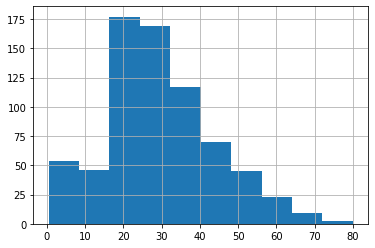

In [101]:
titanic.Age.hist()

<AxesSubplot:>

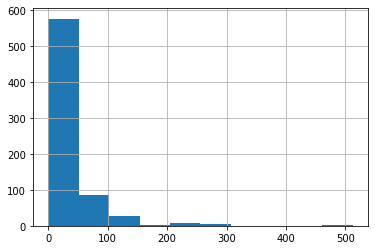

In [102]:
titanic.Fare.hist()

In [103]:
titanic['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
885    39.0
886    27.0
887    19.0
889    26.0
890    32.0
Name: Age, Length: 712, dtype: float64

In [104]:
def classifyAge(x):
    if x<=16:return 0
    elif x>50:return 2
    else: return 1

titanic['Age'] = titanic['Age'].map(classifyAge)
titanic.groupby('Age').count().iloc[:,:1]

,PassengerId
Age,
0,100
1,549
2,63


In [105]:
def classifyFare(x):
    if x<=20:return 0
    elif x>50:return 2
    else: return 1

titanic['Fare'] = titanic['Fare'].map(classifyFare)
titanic.groupby('Fare').count().iloc[:,:1]

,PassengerId
Fare,
0,391
1,185
2,136


### 数据类型转换

将Dateframe格式的数据抽出X和Y，放入输入要求的数组中。

In [133]:
titanic_survive = titanic['Survived']
titanic_X = titanic.drop(labels=['PassengerId','Survived'],axis=1)
titanic_labels = titanic_X.columns.tolist()
print("Label: ",titanic_labels)
titanic_data = titanic[titanic_labels+['Survived']].values.tolist()

Label:  ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [134]:
display(titanic_data[:3])

[[3, 'male', 1, 1, 0, 0, 'S', 0],
 [1, 'female', 1, 1, 0, 2, 'C', 1],
 [3, 'female', 1, 0, 0, 0, 'S', 1]]

## 不算数的简单测试

为什么不算数呢，因为1没有删除多余的print，2没有合并train.test文件[test文件不含survive所以不能用于训练分别，需要提及一下。只能分割train，依据train的结果来判断是否正确。]

In [135]:
treetree = createTree(titanic_data,titanic_labels)
treetree

Feature 0 . infoGain:0.09400998456880605
Feature 1 . infoGain:0.21410831283572307
Feature 2 . infoGain:0.010852205429086492
Feature 3 . infoGain:0.024868993114017024
Feature 4 . infoGain:0.030682011788098373
Feature 5 . infoGain:0.07439877734497358
Feature 6 . infoGain:0.027858206925992057
Feature 0 . infoGain:0.04147079049162472
Feature 1 . infoGain:0.025956515815038994
Feature 2 . infoGain:0.0210431039065464
Feature 3 . infoGain:0.017605070197630468
Feature 4 . infoGain:0.03363541986614105
Feature 5 . infoGain:0.01763005943178475
Feature 0 . infoGain:0.08026391825614954
Feature 1 . infoGain:0.01773307318873829
Feature 2 . infoGain:0.024678088785691887
Feature 3 . infoGain:0.02966830873696502
Feature 4 . infoGain:0.010542020096306559
Feature 0 . infoGain:0.013588530392043219
Feature 1 . infoGain:0.0021602367456079463
Feature 2 . infoGain:0.05679140056535226
Feature 3 . infoGain:0.01999014544677702
Feature 0 . infoGain:0.0
Feature 1 . infoGain:0.04420098937141048
Feature 2 . infoGain:0

{'Sex': {'male': {'Pclass': {1: {'Age': {0: 1,
      1: {'Fare': {0: 0,
        1: {'Parch': {0: {'Embarked': {'C': {'SibSp': {0: 0, 1: 1}},
            'S': {'SibSp': {0: 0, 1: 1}}}},
          1: 0}},
        2: {'Embarked': {'C': {'SibSp': {0: {'Parch': {0: 0, 1: 1, 2: 0}},
            1: {'Parch': {0: 1, 1: 0}}}},
          'Q': 0,
          'S': {'SibSp': {0: 0,
            1: {'Parch': {0: 0, 1: 1, 2: 1}},
            2: 1,
            3: 0}}}}}},
      2: {'Parch': {0: {'Fare': {1: {'Embarked': {'C': {'SibSp': {0: 0, 1: 1}},
            'S': {'SibSp': {0: 0, 1: 1}}}},
          2: 0}},
        1: {'SibSp': {0: 0, 1: {'Embarked': {'C': 1, 'S': 0}}}},
        2: 0,
        4: 0}}}},
    2: {'Age': {0: {'Parch': {0: 0, 1: 1, 2: 1}},
      1: {'Parch': {0: {'Fare': {0: {'Embarked': {'C': 0,
            'S': {'SibSp': {0: 0, 1: 0}}}},
          1: {'SibSp': {0: 0, 1: {'Embarked': {'C': 0, 'S': 0}}}},
          2: 0}},
        1: 0,
        2: 0}},
      2: {'Fare': {0: {'Embarked': {

## 留出法

sklearn有train_test_split，注意stratify参数

## 交叉验证法

kfold

# sk-learn 决策树应用*

使用scikit-learn工具包，实现Titanic数据集的决策树分类，并尝试进行优化。